#  Polarizer optimization

In [1]:
# Add mitsuba and drjit to PATH (this shouldn't be necessary)
import sys
sys.path.append('../../../build/python')

In [2]:
from matplotlib import pyplot as plt

import drjit as dr 
import mitsuba as mi
mi.set_variant('cuda_ad_rgb_polarized')

In [3]:
# TODO would be great no to have to do this!
dr.set_flag(dr.JitFlag.LoopRecord,  False)

# Load scene
scene = mi.load_file('../scenes/polarizers.xml', res=128, max_depth=3)
params = mi.traverse(scene)

2022-02-24 16:27:02 INFO main [xml.cpp:1270] Loading XML file "../scenes/polarizers.xml" with variant "cuda_ad_rgb_polarized"..

2022-02-24 16:27:02 INFO main [Scene] Building scene in OptiX ..

2022-02-24 16:27:02 INFO main [Scene] OptiX ready. (took 37ms)

2022-02-24 16:27:02 INFO main [xml.cpp:1330] Done loading XML file "../scenes/polarizers.xml" (took 74ms).

In [4]:
# Render image: the two filters are aligned and let linearly polarized light through
integrator = scene.integrator()
image_init = integrator.render(scene, seed=0, spp=8)

2022-02-24 16:27:02 INFO main [SamplingIntegrator] Starting render job (128x128, 8 samples)

2022-02-24 16:27:02 INFO main [SamplingIntegrator] Rendering finished. (took 58ms)

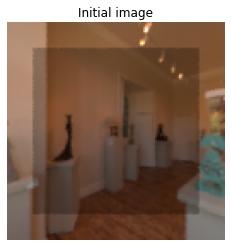

In [5]:
def show_image(img, title):
    plt.imshow(mi.util.convert_to_bitmap(img)); plt.axis('off'); plt.title(title);
    plt.show()

# Show image
show_image(image_init, 'Initial image')
mi.util.write_bitmap('out_init.png', image_init)

In [6]:
# Setup optimizer and differentiable rotation angle that gets applied to mesh vertices

key = 'filter2.vertex_positions'
params.keep([key])
positions_init = dr.unravel(mi.Vector3f, dr.detach(params[key]))

opt = mi.ad.Adam(lr=1.0, params=params)
opt['rotation'] = mi.Float(0.0)

transform = mi.Transform4f.rotate(-mi.Vector3f(0, 0, 1), opt['rotation'])
positions_new = transform @ positions_init
params[key] = dr.ravel(positions_new)

opt.update()

In [7]:
# Optimization loop

mi.set_log_level(mi.LogLevel.Warn)

angles = []
losses = []

for it in range(120):
    scene.sensors()[0].sampler().seed(0)
    # Differentiable rendering
    # TODO: render separately to do unbiased=True
    image = integrator.render(scene, seed=it, spp=1)

#     write_bitmap('out_%03i.png' % it, image)

    # Objective: no comparison against a reference, the goal is simply to make the image darker
    ob_val = dr.hsum_async(image) / len(image)

    # Backpropagate loss to input parameters
    dr.backward(ob_val)

    # Optimizer: take a gradient setp
    opt.step()

    # Apply rotation
    transform = mi.Transform4f.rotate(-mi.Vector3f(0, 0, 1), opt['rotation'])
    positions_new = transform @ positions_init
    params[key] = dr.ravel(positions_new)

    # Optimizer: update the scene parameters
    opt.update()

    print('Iteration %03i, rot: %.5f, loss: %f:' % (it, opt['rotation'][0], ob_val[0]))
    angles.append(opt['rotation'][0])
    losses.append(ob_val[0])

print('Optimization complete!')

Iteration 000, rot: -0.98028, loss: 0.106949:
Iteration 001, rot: -1.93774, loss: 0.106977:
Iteration 002, rot: -2.89243, loss: 0.107100:
Iteration 003, rot: -3.85118, loss: 0.106936:
Iteration 004, rot: -4.81778, loss: 0.106991:
Iteration 005, rot: -5.79419, loss: 0.106780:
Iteration 006, rot: -6.78132, loss: 0.106747:
Iteration 007, rot: -7.77996, loss: 0.106695:
Iteration 008, rot: -8.79055, loss: 0.106501:
Iteration 009, rot: -9.81336, loss: 0.106483:
Iteration 010, rot: -10.84863, loss: 0.106038:
Iteration 011, rot: -11.89642, loss: 0.106037:
Iteration 012, rot: -12.95679, loss: 0.105814:
Iteration 013, rot: -14.02973, loss: 0.105654:
Iteration 014, rot: -15.11516, loss: 0.105372:
Iteration 015, rot: -16.21301, loss: 0.105064:
Iteration 016, rot: -17.32311, loss: 0.104830:
Iteration 017, rot: -18.44526, loss: 0.104526:
Iteration 018, rot: -19.57928, loss: 0.104162:
Iteration 019, rot: -20.72497, loss: 0.103619:
Iteration 020, rot: -21.88206, loss: 0.103551:
Iteration 021, rot: -23

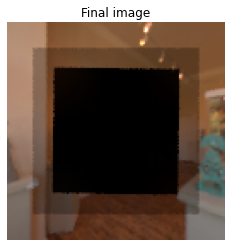

In [8]:
image_final = integrator.render(scene, seed=0, spp=8)
show_image(image_final, 'Final image')
mi.util.write_bitmap('out_final.png', image_final)

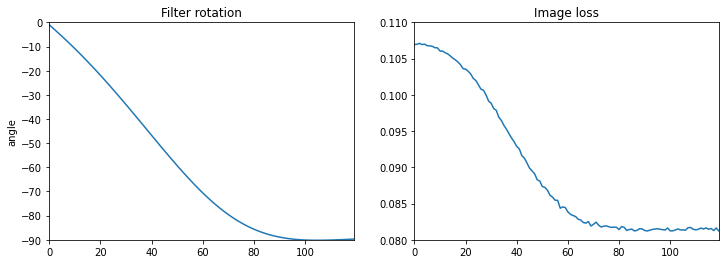

In [9]:
# Plot angles and loss

fig, ax = plt.subplots(ncols=2, figsize=(12,4))
ax[0].plot(angles);
ax[0].set_ylabel('angle'); ax[0].set_title('Filter rotation');
ax[0].set_xlim([0, 119]); ax[0].set_ylim([-90, 0])


ax[1].plot(losses); ax[1].set_title('Image loss')
ax[1].set_xlim([0, 119]); ax[1].set_ylim([0.08, 0.11])

plt.show()